In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import plots
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
wd = os.path.dirname(os.getcwd())

In [3]:
def evolution(country):
    
    gdf_admin_mov = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_rdi_mov_evo.gpkg')

    gdf_admin_mov = gdf_admin_mov.sort_values(by='rdi')

    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    years = ['2020', '2021', '2022']

    for year in years:
        for month in months:  
            try:
                gdf_admin_mov = gdf_admin_mov[gdf_admin_mov['z_score_perchange_' + str(month) + '_' + str(year)] < 4].reset_index(drop=True)
            except:
                continue

    evo_admins = []
    for i in range(len(gdf_admin_mov)):
        evo_admin = []
        for year in years:
            for month in months:
                try:
                    evo_admin.append(gdf_admin_mov.loc[i, 'n_perchange_' + month + '_' + year])
                except:
                    continue
        evo_admins.append(evo_admin)
    evo_admins = np.array(evo_admins)
    
    return gdf_admin_mov, evo_admins

In [4]:
def slope_intercept(gdf_admin_mov, evo_admins):
    
    slopes = []
    intercepts = []
    for i in range(len(evo_admins[0])):

        X = sm.add_constant(gdf_admin_mov['rdi'])
        normal_model_admin = sm.GLM(evo_admins[:,i], X, family=sm.families.Gaussian())
        normal_results_admin = normal_model_admin.fit()
        slopes.append(normal_results_admin.params[1])
        intercepts.append(normal_results_admin.params[0])
    
    return slopes, intercepts

In [6]:
countries = ["ARG", "CHL", "COL", "MEX"]
slopes = []
intercepts = []

for country in countries:
    
    print(country)

    if country == "ARG":
        country_full = "argentina"
    elif country == "CHL":
        country_full = "chile"
    elif country == "COL":
        country_full = "colombia"
    elif country == "MEX":
        country_full = "mexico"
        
    gdf_admin_mov, evo_admins = evolution(country)
    slopes_country, intercept_country = slope_intercept(gdf_admin_mov, evo_admins)
    slopes.append(slopes_country)
    intercepts.append(intercept_country)

ARG
CHL
COL
MEX


In [7]:
df_stringency = pd.read_csv("/Volumes/RECAST/data/covid_stringency/owid-covid-data.csv")
df_stringency = df_stringency[df_stringency['location'] == str(country_full).capitalize()].reset_index(drop=True)
df_stringency = df_stringency.filter(['location', 'date', 'stringency_index'], axis=1)
df_stringency = df_stringency.fillna(0)
df_stringency['monthyear'] = [str(date)[0:7] for date in df_stringency['date']]
monthyears = np.unique(df_stringency['monthyear'])

stringencies = []
for monthyear in monthyears:
    df_stringency_monthyear = df_stringency[df_stringency['monthyear']==monthyear].reset_index(drop=True)
    stringencies.append(np.mean(df_stringency_monthyear['stringency_index']))
    
monthyears = monthyears[3:-10]
stringencies = stringencies[3:-10]

print(monthyears)

['2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10'
 '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05'
 '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12'
 '2022-01' '2022-02' '2022-03' '2022-04' '2022-05']


In [8]:
len(slopes)

4

1 0
4 1
7 2
10 3
13 4
16 5
19 6
22 7


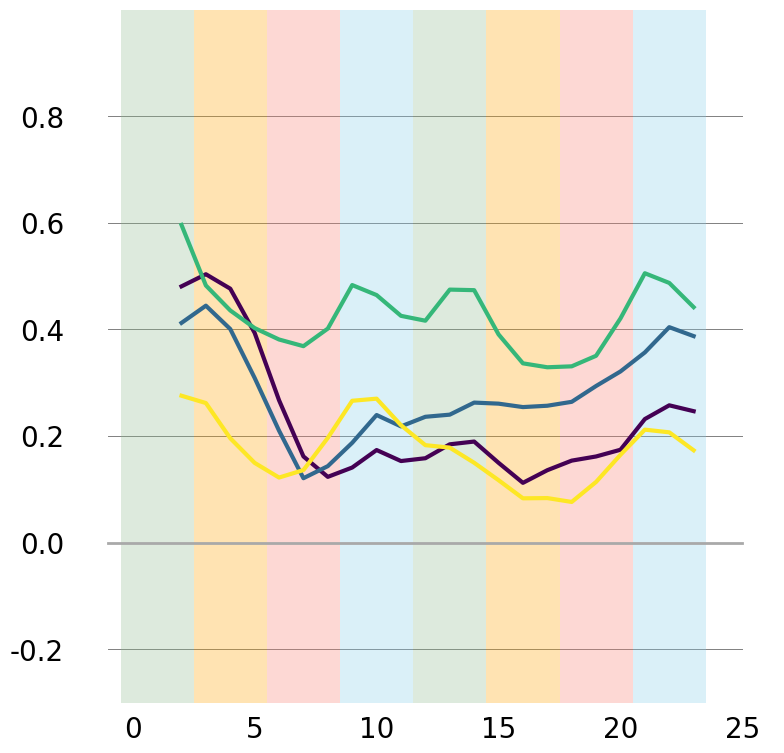

In [19]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

cmap = plt.get_cmap('viridis')
colors = [cmap(i/(len(slopes)-1)) for i in range(len(slopes))]

for i in range(len(slopes)):
    x = np.arange(len(slopes[i]))
    y = slopes[i]
    ax.plot(x, pd.DataFrame(y, columns=['data']).rolling(3).mean(), lw=3, zorder=2, color=colors[i])

xmin, xmax = 0,25
ax.set_ylim([xmin, xmax]) 

ymin, ymax = -0.3,1.0
ax.set_ylim([ymin, ymax])    

yticks = []
for i in range(int(ymin*10), int(ymax*10)):
    if i%2 == 0:
        yticks.append(i/10)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin-1, xmax],[y,y], color='gray', lw=0.7, zorder=0)
# ax.tick_params(axis = 'y', labelsize = 20, pad=6, rotation=0)

ax.plot([xmin-1, xmax],[0,0], color='darkgray', lw=2, zorder=1)


season = ['darkseagreen', 'orange', 'salmon', 'skyblue']
i = 0
for k in range(1,len(x), 3):
    x = [k-1.50, k+1.50]
    print(k,i)
    ax.fill_between(x, 1*np.ones(len(x)), -1*np.ones(len(x)), color=season[i%4], alpha=0.3, edgecolor='None', linewidth=0, zorder=0)
    i += 1   
    
plt.show()

1 0
4 1
7 2
10 3
13 4
16 5
19 6
22 7


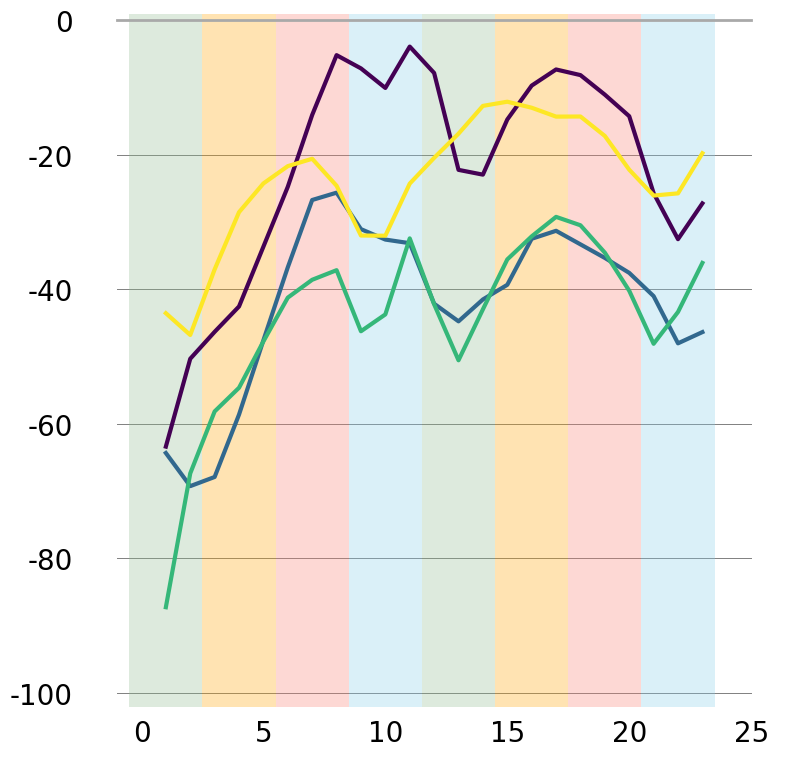

In [27]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

cmap = plt.get_cmap('viridis')
colors = [cmap(i/(len(intercepts)-1)) for i in range(len(intercepts))]

for i in range(len(intercepts)):
    x = np.arange(len(intercepts[i]))
    y = intercepts[i]
    ax.plot(x, pd.DataFrame(y, columns=['data']).rolling(2).mean(), lw=3, zorder=2, color=colors[i])

xmin, xmax = 0,25
ax.set_ylim([xmin, xmax]) 

ymin, ymax = -102,1
ax.set_ylim([ymin, ymax])  

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%20 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin-1, xmax],[y,y], color='gray', lw=0.7, zorder=0)
# ax.tick_params(axis = 'y', labelsize = 20, pad=6, rotation=0)

ax.plot([xmin-1, xmax],[0,0], color='darkgray', lw=2, zorder=1)

season = ['darkseagreen', 'orange', 'salmon', 'skyblue']
i = 0
for k in range(1,len(x), 3):
    x = [k-1.50, k+1.50]
    print(k,i)
    ax.fill_between(x, 1*np.ones(len(x)), -102*np.ones(len(x)), color=season[i%4], alpha=0.3, edgecolor='None', linewidth=0, zorder=0)
    i += 1  
    
plt.show()

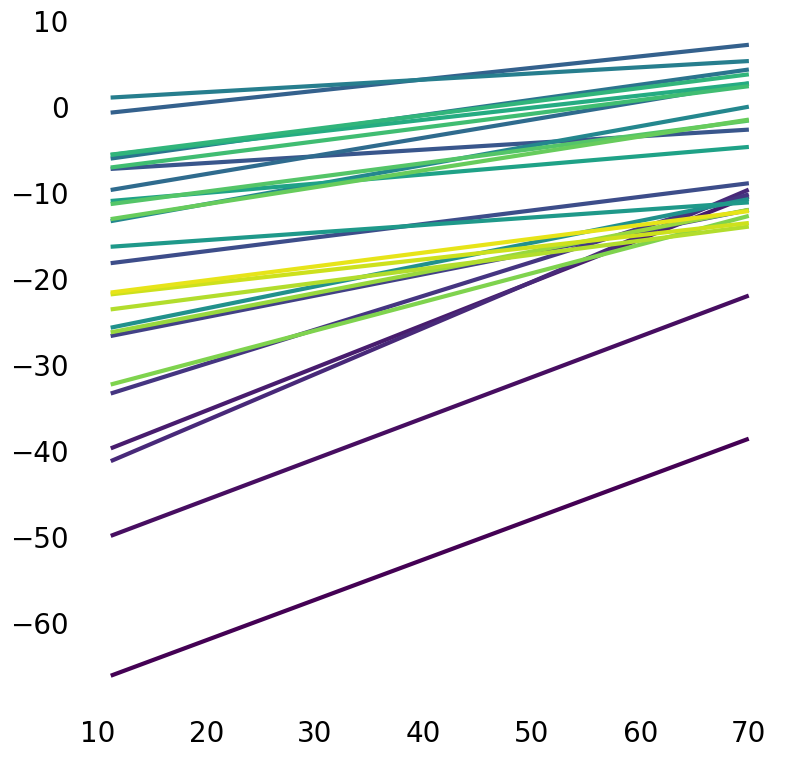

In [5]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

cmap = plt.get_cmap('viridis')
colors = [cmap(i/len(evo_admins[0])) for i in range(len(evo_admins[0]))]


slopes = []
intercepts = []
for i in range(len(evo_admins[0])):
    
    X = sm.add_constant(gdf_admin_mov['rdi'])

    normal_model_admin = sm.GLM(evo_admins[:,i], X, family=sm.families.Gaussian())
    normal_results_admin = normal_model_admin.fit()
    slopes.append(normal_results_admin.params[1])
    intercepts.append(normal_results_admin.params[0])
    ax.plot(gdf_admin_mov['rdi'], normal_results_admin.params[0] + normal_results_admin.params[1]*gdf_admin_mov['rdi'], color=colors[i], lw=3, zorder=2)
#     ax.scatter(gdf_admin_mov['rdi'], evo_admins[:,i], color=colors[i])
    